# Introducción


Para procesamiento de los datos por los modelos para la detección de reseñas falsas, usaremos el conjunto de datos proporcionados por la plataforma <a href="https://www.yelp.es">Yelp</a>, conocidos como <A Href="https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/data">Yelp Dataset</A>, este dataset es un conjunto de datos público que la empresa __Yelp__ pone a disposición para fines académicos, educativos y de investigación personal.  En esencia, la colección de datos son un subconjunto de datos extraídos de la plataforma Yelp y "anonimizado" hasta cierto punto.

<a href="https://business.yelp.com/data/resources/open-dataset/"><img src=https://business.yelp.com/wp-content/themes/yelp-b2b/assets/branding/yelp-data-logo.svg></a>

El DataSet de Yelp se compone de varios conjuntos de datos (ficheros). Para los fines de este trabajo, los más relevantes y que constituyen la fuente principal de información son los siguientes:

1. Business (Establecimientos): Contiene información detallada sobre los negocios, incluyendo su ID único, nombre, ubicación, categorías y otros atributos relevantes.
2. Reviews (Reseñas): Incluye el texto de las reseñas escritas por los usuarios, la puntuación otorgada, así como los identificadores del usuario y del negocio asociado.
3. User (Usuarios): Abarca información sobre los usuarios, como su ID, el número de reseñas que han contribuido, y otros datos demográficos o de actividad disponibles.

De estos tres conjuntos de datos primarios se extraerá toda la información necesaria para llevar a cabo las fases de exploración, selección y evaluación de los datos, y para la posterior aplicación y validación con cada uno de los modelos ML seleccionados.

# Librerías

In [1]:
import polars as pl
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2') 
import seaborn as sns
import openai
from openai import OpenAI
import kagglehub

import json
import time
start_time_global = time.time()
import os
from dotenv import load_dotenv
explicit_work_path = f'/home/aam/fakereviews/'
load_dotenv(dotenv_path=f'{explicit_work_path}.env')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión polars: {pl.__version__}")
print(f"{color}Versión pyarrow: {pyarrow.__version__}")
print(f"{color}Versión numpy: {np.__version__}")
print(f"{color}Versión OpenAI: {openai.__version__}")

Versión pandas: 2.2.3
Versión polars: 1.27.1
Versión pyarrow: 16.1.0
Versión numpy: 2.0.1
Versión OpenAI: 1.75.0


# Datos

## Yelp dataset

El dataset se distribuye en varios ficheros en formato JSON (JavaScript Object Notation), cada uno representando un tipo diferente de información. Los componentes principales son:

* Información de Negocios (business.json): Detalles sobre los establecimientos listados en Yelp, como:
    * Nombre, dirección, coordenadas geográficas.
    * Categorías (restaurante, tienda, peluquería, etc.).
    * Atributos (acepta tarjetas, tiene Wi-Fi, bueno para grupos, etc.).
    * Horarios de apertura.
    * Puntuación media (estrellas).
    * Número de reseñas recibidas.

* Reseñas (review.json): El texto de las reseñas escritas por los usuarios, junto con metadatos como:
    * El texto completo de la reseña.
    * La calificación en estrellas otorgada (de 1 a 5).
    * La fecha de la reseña.
    * El ID del usuario que la escribió.
    * El ID del negocio reseñado.
    * Votos recibidos por la reseña (útil, divertida, genial - "useful, funny, cool").

* Información de Usuarios (user.json): Datos sobre los usuarios que escriben las reseñas:
    * ID del usuario.
    * Nombre (a menudo solo el primer nombre o un identificador).
    * Número total de reseñas escritas.
    * Tiempo siendo usuario de Yelp.
    * Lista de amigos (IDs de otros usuarios).
    * Puntuación media de las reseñas que ha escrito.
    * Número total de votos recibidos por sus reseñas.
    * Estado "Elite" (si lo tiene y en qué años).

* Check-ins (checkin.json): Registros de cuándo los usuarios han indicado ("hecho check-in") que han visitado un negocio.

* Consejos (tip.json): Textos cortos o consejos que los usuarios dejan sobre los negocios, distintos de las reseñas completas.

In [2]:
# Fichero de reseñas
yelp_review_file_path = f'{explicit_work_path}yelp_academic_dataset_review.json'
# Fichero de Información de usuarios
yelp_user_file_path = f'{explicit_work_path}yelp_academic_dataset_user.json'
# Fichero Consejos
yelp_tip_file_path = f'{explicit_work_path}yelp_academic_dataset_tip.json'
# Fichero de Check-ins
yelp_chekin_file_path = f'{explicit_work_path}yelp_academic_dataset_checkin.json'
# Fichero de Información de negocios
yelp_business_file_path = f'{explicit_work_path}yelp_academic_dataset_business.json'

# Análisis Exploratorio

A continuación, se procede con un análisis exploratorio de datos (EDA), motivado principalmente por la naturaleza intrínseca y la heterogeneidad del conjunto de datos de Yelp. Este proceso se llevará a cabo siguiendo las siguientes etapas, consideradas clave para comprender a fondo los datos y preparar el terreno para el modelado:

1. Entender la estructura y complejidad de los datos:
    
    Cada uno de los conjuntos de datos puede estar integrado por múltiples archivos, como se observa en el caso del "Yelp Dataset". Por consiguiente, se estima pertinente proceder a su unificación con el objeto de simplificar la comprensión del corpus y ofrecer una perspectiva clara del volumen de los datos, el cual podrían comprender millones, miles o cientos de reseñas. Adicionalmente, es necesario verificar el formato y los tipos de datos, a modo de ejemplo, las estrellas podrían ser de carácter numérico, las fechas podrían exhibir formatos no válidos, o campos numéricos y podrían encontrarse almacenados como texto.

2. Evaluar la Calidad de los Datos:

    Es importante detectar valores faltantes y determinar la estrategia para su tratamiento, ya sea mediante su eliminación o imputación (ej. negocios que no tienen especificadas las horas).  Asimismo, detectar los errores, incosistencias o datos carentes de lógica (ej. una reseña con 0 estrellas si el rango es 1-5), lo que conduce principalmente a la detección de valores atípicos.

3. Descubrir Patrones e Insights Preliminares:

     El Análisis Exploratorio de Datos (EDA) en el contexto de reseñas requiere la evaluación de la distribución y la correlaciones entre el conjunto de los datos, ej. la longitud de las reseñas y/o el tono empleado, así como los patrones de comportamiento entre los usuarios con más votaciones y los usuarios promedio. Asimismo, el estudio de las variaciones temporales observadas en las reseñas y las valoraciones.

4. Guiar el Análisis Posterior y Modelado:

    El Análisis Exploratorio de Datos (EDA) es fundamental para formular hipótesis basadas en patrones, crear nuevas variables significativas (ingeniería de características), seleccionar modelos de Machine Learning adecuados según la distribución de los datos y validar los supuestos de los modelos estadísticos.

## Yelp dataset

A continuación, damos inicio al análisis EDA del conjunto de datos de Yelp.

### Estructura de los datos

#### Business - Establecimientos

In [3]:
print(f"Iniciando el procesamiento del archivo: {yelp_business_file_path}")
df_lazy_business_pl:pl.lazyframe.frame.LazyFrame = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_lazy_business_pl = pl.scan_ndjson(yelp_business_file_path)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_lazy_business_pl.collect(engine='streaming').limit(25).head(2))

Iniciando el procesamiento del archivo: /home/aam/fakereviews/yelp_academic_dataset_business.json
La operación fue exitosa.


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Doctors, Traditional Chinese M…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Shipping Centers, Local Servic…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"


##### Ajuste de la calidad del dato
A continuación realizaremos la ordenación de las categorías en cada una de las celdas de forma alfabética, ya que esto facilitará cualquier explotación de la información.

In [4]:
start_time=time.time()
try:
    df_data_business_pl:pl.dataframe.frame.DataFrame = df_lazy_business_pl.collect(engine='streaming').with_columns(
        pl.col('categories')
        # 1. Dividir la cadena en una lista de strings, manejando nulos
        .str.split(',')
        # 2. Dentro de cada lista resultante, aplicar operaciones a cada elemento:
        .list.eval(
            # 2a. Quitar espacios en blanco al inicio/final de cada categoría
            pl.element().str.strip_chars()
        )
        # 3. Ordenar los elementos dentro de cada lista
        .list.sort()
        # 4. Unir los elementos de la lista de nuevo en una cadena, separados por ", "
        .list.join(', ')
    )
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    # Muestra las primeras 5 filas del DataFrame  
    display(df_data_business_pl.limit(25).head(5))  

La operación fue exitosa en 1.61seg


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Acupuncture, Doctors, Health &…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Local Services, Mailbox Center…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"
"""tUFrWirKiKi_TAnsVWINQQ""","""Target""","""5255 E Broadway Blvd""","""Tucson""","""AZ""","""85711""",32.223236,-110.880452,3.5,22,0,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",null,""False"",""False"",""False"",""False"",null,null,null,""2"",""False"",""False"",""False"",null,null,""False"",""u'no'"",""True"",""False"",""False"",null,""True"",null,null,null,null,null,null,null,null,null,null}","""Department Stores, Electronics…","{""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-23:0"",""8:0-23:0"",""8:0-22:0""}"
"""MTSW4McQd7CbVtyjqoe9mw""","""St Honore Pastries""","""935 Race St""","""Philadelphia""","""PA""","""19107""",39.955505,-75.155564,4.0,80,1,"{""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"",""False"",null,""False"",null,""True"",""True"",""u'none'"",null,null,""1"",""False"",null,null,null,null,""False"",""u'free'"",null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null}","""Bakeries, Bubble Tea, Coffee &…","{""7:0-20:0"",""7:0-20:0"",""7:0-20:0"",""7:0-20:0"",""7:0-21:0"",""7:0-21:0"",""7:0-21:0""}"
"""mWMc6_wTdE0EUBKIGXDVfA""","""Perkiomen Valley Brewery""","""101 Walnut St""","""Green Lane""","""PA""","""18054""",40.338183,-75.471659,4.5,13,1,"{""{'garage': None, 'street': None, 'validated': None, 'lot': True, 'valet': False}"",""True"",null,null,null,""False"",""True"",null,null,""True"",null,null,null,null,null,null,null,null,""True"",null,null,null,""True"",null,null,null,null,null,null,null,null,null,null}","""Breweries, Brewpubs, Food""","{null,null,""14:0-22:0"",""16:0-22:0"",""12:0-22:0"",""12:0-22:0"",""12:0-18:0""}"


#### Chekin - Ha visitado el establecimiento

In [5]:
print(f"Iniciando el procesamiento del archivo: {yelp_chekin_file_path}")
df_data_chekin_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_chekin = pl.scan_ndjson(yelp_chekin_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_chekin_pl = df_data_chekin.limit(25).collect(engine='streaming') 
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_chekin_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: /home/aam/fakereviews/yelp_academic_dataset_checkin.json
La operación fue exitosa.


business_id,date
str,str
"""---kPU91CF4Lq2-WlRu9Lw""","""2020-03-13 21:10:56, 2020-06-0…"
"""--0iUa4sNDFiZFrAdIWhZQ""","""2010-09-13 21:43:09, 2011-05-0…"
"""--30_8IhuyMHbSOcNWd6DQ""","""2013-06-14 23:29:17, 2014-08-1…"
"""--7PUidqRWpRSpXebiyxTg""","""2011-02-15 17:12:00, 2011-07-2…"
"""--7jw19RH9JKXgFohspgQw""","""2014-04-21 20:42:11, 2014-04-2…"


#### Review - Reseñas

In [6]:
print(f"Iniciando el procesamiento del archivo: {yelp_review_file_path}")
df_lazy_review_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_lazy_review_pl = pl.scan_ndjson(yelp_review_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")

Iniciando el procesamiento del archivo: /home/aam/fakereviews/yelp_academic_dataset_review.json
La operación fue exitosa.


Cargar todas las reseñas

In [7]:
start_time=time.time()
try:    
    df_data_review_pl = df_lazy_review_pl.collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")
    display(df_data_review_pl.head(5))

La operación fue exitosa en 4.53seg


review_id,user_id,business_id,stars,useful,funny,cool,text,date
str,str,str,f64,i64,i64,i64,str,str
"""KU_O5udG6zpxOg-VcAEodg""","""mh_-eMZ6K5RLWhZyISBhwA""","""XQfwVwDr-v0ZS3_CbbE5Xw""",3.0,0,0,0,"""If you decide to eat here, jus…","""2018-07-07 22:09:11"""
"""BiTunyQ73aT9WBnpR9DZGw""","""OyoGAe7OKpv6SyGZT5g77Q""","""7ATYjTIgM3jUlt4UM3IypQ""",5.0,1,0,1,"""I've taken a lot of spin class…","""2012-01-03 15:28:18"""
"""saUsX_uimxRlCVr67Z4Jig""","""8g_iMtfSiwikVnbP2etR0A""","""YjUWPpI6HXG530lwP-fb2A""",3.0,0,0,0,"""Family diner. Had the buffet. …","""2014-02-05 20:30:30"""
"""AqPFMleE6RsU23_auESxiA""","""_7bHUi9Uuf5__HHc_Q8guQ""","""kxX2SOes4o-D3ZQBkiMRfA""",5.0,1,0,1,"""Wow! Yummy, different, delic…","""2015-01-04 00:01:03"""
"""Sx8TMOWLNuJBWer-0pcmoA""","""bcjbaE6dDog4jkNY91ncLQ""","""e4Vwtrqf-wpJfwesgvdgxQ""",4.0,1,0,1,"""Cute interior and owner (?) ga…","""2017-01-14 20:54:15"""


Debido a la longitud de las reseñas y a que posiblemente las reseñas más largas tienden a contener más información contextual, detalles y características lingüísticas que pueden ser cruciales para identificar patrones asociados con reseñas falsas, pero no todo el texto en una reseña es útil, por ejemplo una reseña muy larga no es necesariamente útil o relevante para determinar si es falsa, ya que, pueden contener mucha información superflua, anécdotas personales o repeticiones que actúan como "ruido" y pueden dificultar que el modelo identifique las señales clave.  Es por ello que el segmento de datos seleccionados es de reseñas con una longitud mínima de __256__ y máxima de __512__ de longitud.

In [8]:
start_time=time.time()
try: 
    filter_reviews_min_lenght = 256
    filter_reviews_max_lenght = 512
    print("-" * 50)
    df_data_review_pl = df_data_review_pl.with_columns(
        pl.col("text").str.len_chars().alias("length")
    )
    print(f'Total reseñas seleccionadas: {df_data_review_pl.shape[0]}')
    df_data_review_pl = df_data_review_pl.filter(
       (pl.col("length") >= filter_reviews_min_lenght) & (pl.col("length") <= filter_reviews_max_lenght)
    ).sort('length', descending=False)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")
    print(f'Total reseñas seleccionadas {df_data_review_pl.shape[0]} con una longitud en el texto superior a {filter_reviews_min_lenght} y menor a {filter_reviews_max_lenght}')    
    display(df_data_review_pl.head(5))


--------------------------------------------------
Total reseñas seleccionadas: 6990280
La operación fue exitosa.
La operación fue exitosa en 1.45seg
Total reseñas seleccionadas 2191389 con una longitud en el texto superior a 256 y menor a 512


review_id,user_id,business_id,stars,useful,funny,cool,text,date,length
str,str,str,f64,i64,i64,i64,str,str,u32
"""4KpIldEM-tdnrJLqYzRfZQ""","""Z5j9Xw_G0c7M2b1-iS67wg""","""HTqXI5S2XcSlh_ylx9sE6g""",5.0,1,1,1,"""I've only had the cannolis her…","""2018-03-23 14:35:33""",256
"""ZWpJSXuUDFnw8_NZh6JqYA""","""BxHWwl5P0NH34Ei9ZdaBjQ""","""lwdkX7KcibM4mDqpDfK7JA""",4.0,0,0,0,"""Love the lamb gyros plate. It'…","""2013-10-03 12:41:19""",256
"""asXAASywqWEx4lS6PU-r_g""","""lTx02VrbU_YYRffLehyVgg""","""TgbI5_wXWa82NBVwkvC0yQ""",5.0,0,0,0,"""We've stayed at this Courtyard…","""2017-04-19 20:52:17""",256
"""7L1JrN4YIEVy98m_8_ebhA""","""QjyrAYCPSc93N5NVTMWUnA""","""gzln_L7ch8z-Ob6autmumw""",2.0,1,0,0,"""We were drawn in by the full p…","""2015-01-03 23:53:47""",256
"""sFzKQcym9BcMa3HceZ4AqQ""","""9jlF9iq-Zz8NhQ-ezrCCNQ""","""YKpZ2Ml0NZoYZ5eb3r_Cdg""",5.0,0,0,0,"""Hands down, one of the BEST st…","""2016-06-12 04:10:33""",256


#### Tips - Consejos

In [9]:
print(f"Iniciando el procesamiento del archivo: {yelp_tip_file_path}")
df_data_tip_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_tip = pl.scan_ndjson(yelp_tip_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_tip_pl = df_data_tip.limit(25).collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_tip_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: /home/aam/fakereviews/yelp_academic_dataset_tip.json
La operación fue exitosa.


user_id,business_id,text,date,compliment_count
str,str,str,str,i64
"""AGNUgVwnZUey3gcPCJ76iw""","""3uLgwr0qeCNMjKenHJwPGQ""","""Avengers time with the ladies.""","""2012-05-18 02:17:21""",0
"""NBN4MgHP9D3cw--SnauTkA""","""QoezRbYQncpRqyrLH6Iqjg""","""They have lots of good deserts…","""2013-02-05 18:35:10""",0
"""-copOvldyKh1qr-vzkDEvw""","""MYoRNLb5chwjQe3c_k37Gg""","""It's open even when you think …","""2013-08-18 00:56:08""",0
"""FjMQVZjSqY8syIO-53KFKw""","""hV-bABTK-glh5wj31ps_Jw""","""Very decent fried chicken""","""2017-06-27 23:05:38""",0
"""ld0AperBXk1h6UbqmM80zw""","""_uN0OudeJ3Zl_tf6nxg5ww""","""Appetizers.. platter special f…","""2012-10-06 19:43:09""",0


#### Users - Usuarios

In [10]:
print(f"Iniciando el procesamiento del archivo: {yelp_user_file_path}")
df_data_user_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_user = pl.scan_ndjson(yelp_user_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_user_pl = df_data_user.limit(25).collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_user_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: /home/aam/fakereviews/yelp_academic_dataset_user.json
La operación fue exitosa.


user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
str,str,i64,str,i64,i64,i64,str,str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""qVc8ODYU5SZjKXVBgXdI7w""","""Walker""",585,"""2007-01-25 16:47:26""",7217,1259,5994,"""2007""","""NSCy54eWehBJyZdG2iE84w, pe42u7…",267,3.91,250,65,55,56,18,232,844,467,467,239,180
"""j14WgRoU_-2ZE1aw1dXrJg""","""Daniel""",4333,"""2009-01-25 04:35:42""",43091,13066,27281,"""2009,2010,2011,2012,2013,2014,…","""ueRPE0CX75ePGMqOFVj6IQ, 52oH4D…",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946
"""2WnXYQFK0hXEoTxPtV2zvg""","""Steph""",665,"""2008-07-25 10:41:00""",2086,1010,1003,"""2009,2010,2011,2012,2013""","""LuO3Bn4f3rlhyHIaNfTlnA, j9B4Xd…",52,3.32,89,13,10,17,3,66,96,119,119,35,18
"""SZDeASXq7o05mMNLshsdIA""","""Gwen""",224,"""2005-11-29 04:38:33""",512,330,299,"""2009,2010,2011""","""enx1vVPnfdNUdPho6PH_wg, 4wOcvM…",28,4.27,24,4,1,6,2,12,16,26,26,10,9
"""hA5lMy-EnncsH4JoR-hFGQ""","""Karen""",79,"""2007-01-05 19:40:59""",29,15,7,"""""","""PBK4q9KEEBHhFvSXCUirIw, 3FWPpM…",1,3.54,1,1,0,0,0,1,1,0,0,0,0


### Patrones visuales de los datos

#### Business - Establecimientos
A continuación hacemos una exploración visual de las categorías de los establecimientos y así respresentar el grupo de categorías que más comentarios contiene del fichero [business](yelp_academic_dataset_business.json)

In [24]:
start_time=time.time()
try:
    #Agrupación por la categoría
    max_categorias_business = 30
    df_count_categories_business_pl = df_data_business_pl.group_by("categories").agg(
        pl.len().alias("count")  # pl.count() cuenta las filas en cada grupo
    ).sort("count", descending=True)
    df_count_categories_business_pl = df_count_categories_business_pl.limit(max_categorias_business)
    
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    # Muestra las primeras 5 filas del DataFrame  
    print("-" * 50 + "\n")
    # Ver el resultado
    print(f'Resultado de la agrupación, total {df_count_categories_business_pl.shape}')
    #display(df_count_categories_business_pl.head(5)) 

La operación fue exitosa en 0.11seg
--------------------------------------------------

Resultado de la agrupación, total (30, 2)


Convertir a pandas para graficar las categorias más usadas por los establecimientos.

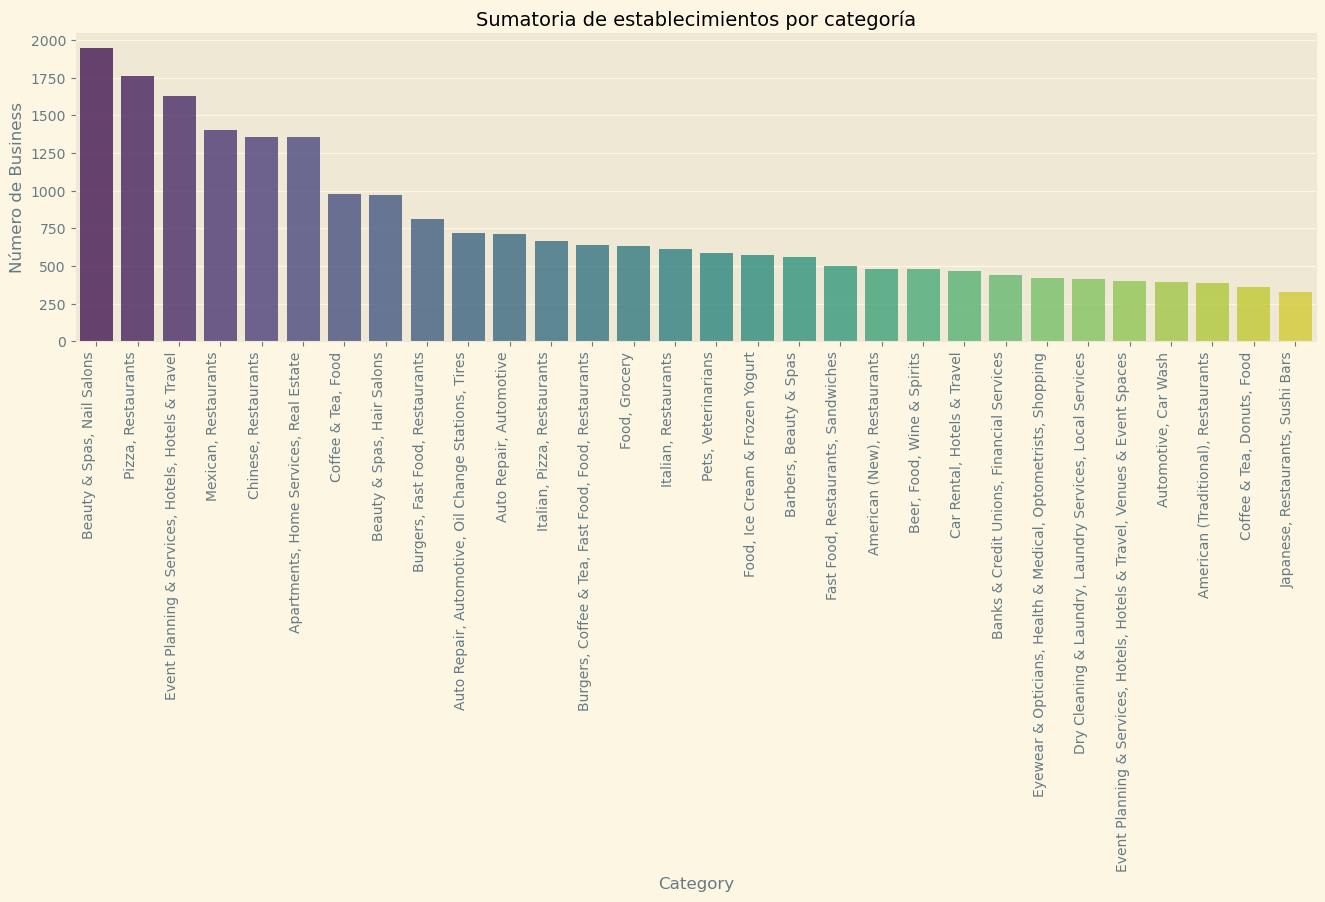

Total establecimientos: 23009 de 150346


In [12]:
# Convertir a pandas para graficar
df_category_counts_pd = df_count_categories_business_pl.to_pandas()
plt.figure(figsize=(16,4))
sns.barplot(x='categories', y='count',data=df_category_counts_pd, alpha=0.8, palette='viridis',hue='categories')
plt.title("Sumatoria de establecimientos por categoría",fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Número de Business', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()
print(f'Total establecimientos: {df_category_counts_pd['count'].sum()} de {df_data_business_pl.shape[0]}')


#### Review - Reseñas

A continuación, observamos la distribución de las estrellas del fichero [review](yelp_academic_dataset_review_selected.jsonl)

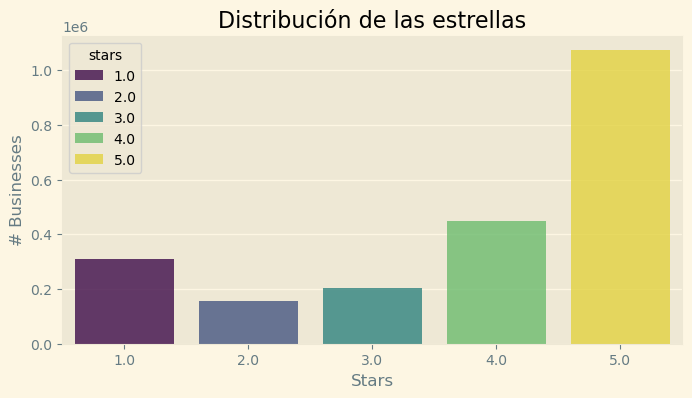

In [14]:
#Distribución grupal
x=df_data_review_pl['stars'].value_counts().sort('count', descending=True)
plt.figure(figsize=(8,4))
ax= sns.barplot(x='stars', y='count',data=x, alpha=0.8,hue='stars',palette='viridis')
plt.title("Distribución de las estrellas")
plt.ylabel('# Businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)
plt.show()

A continuación, observamos la distribución de la longitud de las reseñas.

In [43]:
plt.figure(figsize=(8, 4)) # Tamaño de la figura

# Seaborn histplot
# 'data' es el DataFrame
# 'x' es el nombre de la columna que quieres graficar en el eje X
# 'bins' funciona igual que en Matplotlib ('auto', número fijo, etc.)
# 'kde=True' (opcional) añade una Estimación de Densidad del Kernel (una línea suave)
# 'color' permite establecer un color único para todas las barras (ej: 'skyblue', 'viridis')
# 'palette' y 'hue' se usan juntos para colorear barras basado en OTRA columna categórica

sns.histplot(data=df_data_review_pl.to_pandas(), # Seaborn a menudo funciona mejor con Pandas DataFrames
                x='length',
                bins=30, # O usa 'auto', 30, 100, etc.
                # color='teal', # Descomenta para un color único
                # palette='viridis', # Las paletas se usan típicamente con 'hue'
                # hue='stars', # Descomenta si quieres histogramas separados/apilados por estrellas, coloreados por la paleta
                edgecolor='black',
                alpha=0.7,
                kde=True # Añade la curva de densidad (opcional)
            )

# Añade títulos y etiquetas usando Matplotlib (Seaborn grafica SOBRE Matplotlib)
plt.title('Distribución de la Longitud de las Reseñas (Seaborn)', fontsize=16)
plt.xlabel('Longitud de la Reseña', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12) # histplot etiqueta automáticamente el eje Y como 'Count' o similar, pero puedes añadir o modificar con plt.ylabel

# La cuadrícula se añade automáticamente por el estilo por defecto de Seaborn,
# pero podrías forzarla con plt.grid(axis='y', alpha=0.75) si fuera necesario.


# Muestra el gráfico
plt.show()

: 

### Guardar las reseñas seleccionadas

In [ ]:
# Guardar este DataFrame como archivo Parquet
df_data_reviews_selected_pl = df_data_reviews_filer_pl.select(pl.col('text'))
review_selected_file_path = f'{explicit_work_path}yelp_academic_dataset_review_selected.jsonl'
df_data_reviews_selected_pl.write_json(review_selected_file_path)

# Información de sesión

In [20]:
import session_info
session_info.show(html=False)

-----
dotenv              NA
kagglehub           0.2.7
matplotlib          3.10.0
numpy               2.0.1
openai              1.75.0
pandas              2.2.3
polars              1.27.1
pyarrow             16.1.0
seaborn             0.13.2
session_info        v1.0.1
-----
IPython             9.1.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.3.4
notebook            7.3.2
-----
Python 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-04-27 20:03


# Instalación librerías

!conda create --name tfm python=3.12.2

!conda activate tfm

!conda install -y conda-forge::polars=1.27.1

!conda install -y anaconda::pandas=2.2.3

!conda install -y seaborn=0.13.2

!conda install -y matplotlib=3.10.0

!conda install -c conda-forge pyarrow=16.1.0

!conda install -y conda-forge::python-dotenv-with-cli

!conda install -y conda-forge::openai=1.75.0

!conda install -y conda-forge::kaggle

!conda install -y anaconda::kagglehub

!conda install -y anaconda::jupyter

!pip install session_info

# Total ejecución del notebook

In [21]:
print(f'Total ejecución {time.time() - start_time_global:.2f} segundos')

Total ejecución 313.79 segundos
